In [1]:
import re
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer

from rdflib import Graph, Literal, URIRef, Namespace, BNode, Literal, Bag
from rdflib.namespace import RDF, RDFS, SH, FOAF, XSD
from rdflib.container import Container
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx

from pyshacl import validate

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### Lecture des tables de données - Reading data tables

#### Table INCA2 / CIQUAL2020

In [3]:
# liste des ingrédients - list of ingredients 
df_ingredients = pd.read_excel("ressources/recettes_inca2_v1.xlsx", sheet_name="Liste_Ingrédients")

# liste des recettes/aliments  - list of recepies or foood
df_recettes = pd.read_excel("ressources/recettes_inca2_v1.xlsx", sheet_name="Liste_Recettes")

# liste des ingrédients de chaque aliments  - list of ingredients for each food such as the items avaialble in food
df_detail = pd.read_excel("ressources/recettes_inca2_v1.xlsx", sheet_name="Détail_Recettes")

# les groupes et sous groupes de chaque aliments - the groups and subgroups of each food
df_nomen = pd.read_csv("ressources/Nomenclature_3.csv", sep=";", encoding="windows-1252")

# la composition nutritionnelle de chaque ingrédient CIQUAL - the nutritional composition of each CIQUAL ingredient
df_ciqual = pd.read_excel("ressources/Table Ciqual 2020_FR_2020 07 07.xls", sheet_name="compo")

# liste des indivius - list of individuals
df_indiv = pd.read_csv("ressources/Table_indiv.csv", sep=";", encoding="windows-1252")
df_indiv = df_indiv.loc[df_indiv["tage"] > 3]

# consommation de chaque individu par jour et par repas - consumption of each individual per day and per meal
df_conso = pd.read_csv("ressources/Table_conso.csv", sep=";", encoding="windows-1252")
df_conso = df_conso.loc[df_conso["tyrep"].isin([1, 3, 5]) & df_conso["nomen"].isin(df_indiv["nomen"])]

C:\Users\nigit\AppData\Local\Temp\ipykernel_31964\2724866846.py:17: DtypeWarning: Columns (150,151,152,153,154,155) have mixed types. Specify dtype option on import or set low_memory=False.
  df_indiv = pd.read_csv("ressources/Table_indiv.csv", sep=";", encoding="windows-1252")


In [4]:
df_nomen.head()

codgr                       libgr  sougr libsougr  codal  \
0      1  pain et panification sèche      1     pain   7001   
1      1  pain et panification sèche      1     pain   7004   
2      1  pain et panification sèche      1     pain   7012   
3      1  pain et panification sèche      1     pain   7100   
4      1  pain et panification sèche      1     pain   7110   

                                     libal  
0                            pain baguette  
1                       pain grillé maison  
2  pain courant français boule à la levure  
3                  pain de campagne ou bis  
4       pain complet ou intégral artisanal

In [5]:
df_ingredients.head(10)

IDING                                       LIBING  \
0      1                                   eau-de-vie   
1      2                                         rhum   
2      3           apéritif à base de vin ou vermouth   
3      4                                        vodka   
4      5                              crème de cassis   
5      6  jus d'ananas à base de concentré pasteurisé   
6      7               pur jus de carottes pasteurisé   
7      8                                jus de citron   
8      9  jus d'orange à base de concentré pasteurisé   
9     10                         jus d'orange pressée   

                              TYPING                SOURCE  
0  Ingrédient brut ou peu transformé   CIQUAL - base REGAL  
1  Ingrédient brut ou peu transformé   CIQUAL - base REGAL  
2  Ingrédient brut ou peu transformé   CIQUAL - base REGAL  
3  Ingrédient brut ou peu transformé  CIQUAL - base REGALa  
4  Ingrédient brut ou peu transformé   CIQUAL - base REGAL  
5  Ingrédient brut ou peu transformé   CIQUAL - base REGAL  
6  Ingrédient brut ou peu transformé   CIQUAL - base REGAL  
7  Ingrédient brut ou peu transformé   CIQUAL - base REGAL  
8              Ingrédient transformé   CIQUAL - base REGAL  
9  Ingrédient brut ou peu transformé   CIQUAL - base REGAL

In [6]:
df_ingredients.shape

(760, 4)

#### df_conso

the table is about consumption of 4079 people for 6 differnt time(type) of food per day( 3, breakfast, lunch and dinner and 3 during these )

In [7]:
df_conso.head()
# libmarq typal3 nom_commercial nomen numlig nojour tyrep noligne codgr sougr codal algra alsuc enric diete rien typal2 qte_brute qte_nette

libmarq  typal3                        nom_commercial   nomen  \
0           summa aldi       2                                     x  110006   
1           tutti free       1                                     x  110006   
2                    x       3                                     x  110006   
3  marque repère nadya       1  margarine allégée de tournesol 55%mg  110006   
4             albacore       1                                     x  110006   

   numlig  nojour  tyrep  noligne  codgr  sougr  codal  algra  alsuc  enric  \
0     1.0       6      1      1.0     34     99  18151    0.0    0.0    0.0   
1     2.0       6      1      2.0     30      1  31076    0.0    1.0    0.0   
2     3.0       6      1      3.0      1      1   7001    0.0    0.0    0.0   
3     4.0       6      1      4.0     15     99  16632    1.0    0.0    0.0   
4     5.0       6      3      1.0     21      1  26039    0.0    0.0    0.0   

   diete  rien  typal2  qte_brute  qte_nette  
0    0.0   1.0     4.0      250.0      250.0  
1    0.0   0.0     4.0        2.5        2.5  
2    0.0   1.0     1.0       30.0       30.0  
3    0.0   0.0     1.0        5.0        5.0  
4    0.0   1.0     2.0       30.0       30.0

#### df_nomen
This table gives the labels of the groups, subgroups and the 1343 foods (1 of which corresponds to the 
non-coded foods CODAL=1) of the food nomenclature used for the CNIB 2 study. 
This table contains 1343 observations and 6 variables presented below.

In [8]:
df_nomen.head()

codgr                       libgr  sougr libsougr  codal  \
0      1  pain et panification sèche      1     pain   7001   
1      1  pain et panification sèche      1     pain   7004   
2      1  pain et panification sèche      1     pain   7012   
3      1  pain et panification sèche      1     pain   7100   
4      1  pain et panification sèche      1     pain   7110   

                                     libal  
0                            pain baguette  
1                       pain grillé maison  
2  pain courant français boule à la levure  
3                  pain de campagne ou bis  
4       pain complet ou intégral artisanal

In [9]:
df_conso.shape

(321939, 19)

In [10]:
df_ingredients.shape

(760, 4)

#### Données externes

In [11]:
# in english
# food_categories = {
#      0: ['tap water', 'spring water', 'uht semi-skimmed milk', 'fresh orange', 'orange juice from pasteurized concentrate', 'fresh unpeeled apple', 'skimmed milk uht', 'fresh banana', 'home-squeezed orange juice', 'pure pasteurized orange juice', 'unspecified fruit juice', 'fresh kiwi'],
#      1: ['baguette bread', 'country bread or bis', 'common French yeast ball bread', 'artisanal wholemeal or wholemeal bread', 'classic Heudebert lu type rusk', 'homemade toast', 'bread de mie', 'other rusk', 'artisanal cereal bread'],
#      2: ['reduced fat 60% m.g.', 'reduced fat 55-60% m.g. rich in omega 3 and 6', 'soft butter', 'semi-salted butter maxi salt 3%', 'light fat 38-41% m.g. to spread', 'unspecified low-fat butter'],
#      3: ['coffee with milk or café crème or unsweetened cappuccino', 'unsweetened ready-to-drink black coffee', 'unsweetened brewed tea', 'unsweetened reconstituted ready-to-drink instant coffee', 'cocoa and sweetened powder for chocolate drink', 'unsweetened espresso coffee'],
#      4: ['prepackaged industrial brioche', 'unspecified croissant', 'artisanal flaky chocolate bread', 'unspecified brioche', 'artisanal butter croissant', 'Nutella-type chocolate and hazelnut spread', ' madeleine', 'artisanal milk bread', 'dry snack filled with chocolate like prince or bn au chocolat'],
#      5: ['white sugar', 'white sugar added to service', 'aspartame sweetener', 'brown sugar', 'uncodified food'],
#      6: ['jam or marmalade of any type', 'fresh clementine or mandarin', 'yoghurt or plain dairy specialty', 'honey', 'strawberry jam', 'apricot jam', 'low-fat jam'],
#      7: ['soluble powder made from chicory and ricoré-type coffee', 'soluble coffee powder']
# }

In [12]:
food_categories = {
    0: ['eau du robinet', 'eau de source', 'lait demi-écrémé uht', 'orange fraîche', "jus d'orange à base de concentré pasteurisé", 'pomme non pelée fraîche', 'lait écrémé uht', 'banane fraîche', "jus d'orange pressé maison", "pur jus d'orange pasteurisé", 'jus de fruits sans précision', 'kiwi frais'],
    1: ['pain baguette', 'pain de campagne ou bis', 'pain courant français boule à la levure', 'pain complet ou intégral artisanal', 'biscotte classique type heudebert lu', 'pain grillé maison', 'pain de mie', 'autre biscotte', 'pain aux céréales artisanal'],
    2: ['matière grasse allégée 60% m.g.', 'matière grasse allégée 55-60% m.g. riche en oméga 3 et 6', 'beurre doux', 'beurre demi-sel sel maxi 3%', 'matière grasse légère 38-41% m.g. à tartiner', 'beurre allégé sans précision'],
    3: ['café au lait ou café crème ou cappuccino non sucré', 'café noir prêt à boire non sucré', 'thé infusé non sucré', 'café soluble reconstitué prêt à boire non sucré', 'poudre cacaotée et sucrée pour boisson au chocolat', 'café expresso non sucré'],
    4: ['brioche industrielle préemballée', 'croissant sans précision', 'pain au chocolat feuilleté artisanal', 'brioche sans précision', 'croissant au beurre artisanal', 'pâte à tartiner au chocolat et aux noisettes type nutella', 'madeleine', 'pain au lait artisanal', 'goûter sec fourré au chocolat type prince ou bn au chocolat'],
    5: ['sucre blanc', 'sucre blanc ajouté au service', "édulcorant à l'aspartame", 'sucre roux', 'aliment non codifié'],
    6: ['confiture ou marmelade tout type', 'clémentine ou mandarine fraîche', 'yaourt ou spécialité laitière nature', 'miel', 'confiture de fraise', "confiture d'abricot", 'confiture allégée'],
    7: ['poudre soluble à base de chicorée et de café type ricoré', 'café soluble en poudre']
}

In [13]:
# liste des allergènes --- list of allergens
with open("ressources/allergens.txt", "r") as file:
    allergenes = [line[3:] for line in file.read().split("\n") if re.match(r"fr:", line)]

allergenes = [line.split(", ") for line in allergenes]
allergenes = {line[0]: line for line in allergenes}
# pprint(list(allergenes.keys()))
allergenes

{'gluten': ['gluten',
  'blé',
  'seigle',
  'orge',
  'épeautre',
  'kamut',
  'son de blé',
  'blé complet',
  'gluten de blé',
  'fibre de blé',
  "malt d'orge",
  'malt',
  'froment',
  'farine de blé',
  'farine de froment',
  'boulgour',
  'petit épeautre',
  'céréales contenant du gluten',
  'blé dur',
  'épeautre',
  'petit épeautre',
  'grand épeautre',
  "farine d'épeautre"],
 'crustacés': ['crustacés',
  'crustacé',
  'crabe',
  'crabes',
  'homard',
  'homards',
  'langouste',
  'langoustine',
  'gambas',
  'crevettes',
  'crevette',
  'écrevisses',
  'écrevisse'],
 'œufs': ['œufs',
  'œuf',
  'oeufs',
  'oeuf',
  "blanc d'oeuf",
  "jaune d'oeuf",
  "blanc d'œuf",
  "jaune d'œuf",
  "blanc d'oeufs",
  "jaune d'oeufs",
  "blanc d'œufs",
  "jaune d'œufs",
  'oeuf frais',
  'œuf frais',
  'œufs frais',
  'oeufs frais'],
 'poisson': ['poisson',
  'poissons',
  'cabillaud',
  'morue',
  'maquereau',
  'flétan',
  'turbot',
  'colin',
  'haddock',
  'aiglefin',
  'saumon',
  'sol

['gluten',
  'shellfish',
  'eggs',
  'fish',
  'peanuts',
  'soy',
  'milk',
  'nuts',
  'celery',
  'mustard',
  'Sesame seeds',
  'sulfur dioxide and sulphites',
  'lupine',
  'molluscs']

In [14]:
# jointure entre ingrédients INCA2 et CIQUAL2020 ---- join between INCA2 and CIQUAL2020 ingredients
df_matches_ = pd.read_csv("ressources/matches.csv", sep=";")
df_matches_["6"].fillna(1.0, inplace=True)

df_matches = pd.DataFrame()
df_matches["inca"] = df_matches_["0"]
df_matches["ciqual"] = df_matches_.apply(lambda x: x[str(int(x["6"]))], axis="columns")

In [15]:
df_matches.head()

inca                              ciqual
0                          eau-de-vie                          Eau de vie
1                                rhum                                Rhum
2  apéritif à base de vin ou vermouth  Apéritif à base de vin ou vermouth
3                               vodka                               Vodka
4                     crème de cassis                     Crème de cassis

In [42]:
df_matches_.head(5)

0                                   1  \
0                          eau-de-vie                          Eau de vie   
1                                rhum                                Rhum   
2  apéritif à base de vin ou vermouth  Apéritif à base de vin ou vermouth   
3                               vodka                               Vodka   
4                     crème de cassis                     Crème de cassis   

                                                                    2  \
0  Eau minérale, embouteillée, faiblement minéralisée (aliment moyen)   
1                                                        Baba au rhum   
2                                                 Vin (aliment moyen)   
3                                                                 NaN   
4                                                         Cassis, cru   

                                                            3  \
0                                                 Eau de coco   
1                                    Baba au rhum, préemballé   
2                   Escalope végétale ou steak à base de soja   
3                                                         NaN   
4  Spécialité à base de crème légère 8% MG, fluide ou épaisse   

                                                                                                       4  \
0                                                                             Eau embouteillée de source   
1                                                                                Cocktail à base de rhum   
2                                                                               Base de pizza à la crème   
3                                                                                                    NaN   
4  Crème de lait ou spécialité à base de crème légère, teneur en matière grasse inconnue (aliment moyen)   

                                             5    6  
0  Eau de source, embouteillée (aliment moyen)  1.0  
1                                          NaN  1.0  
2                        Vinaigre de vin rouge  1.0  
3                                          NaN  1.0  
4                             Crème de marrons  1.0

In [17]:
df_matches_.shape

(760, 7)

In [18]:
# liste des nutriments ciqual {code: libellé} -- list of ciqual nutrients {code: label}
nutriments = {
    'energie_kj': 'Energie, Règlement UE N° 1169/2011 (kJ/100 g)',
    'energie_kcal': 'Energie, Règlement UE N° 1169/2011 (kcal/100 g)',
    'energie_jones_fibre_kj': 'Energie, N x facteur Jones, avec fibres  (kJ/100 g)',
    'energie_jones_fibre_kcal': 'Energie, N x facteur Jones, avec fibres  (kcal/100 g)',
    'eau_g': 'Eau (g/100 g)',
    'proteines_jones_g': 'Protéines, N x facteur de Jones (g/100 g)',
    'proteines_6_25_g': 'Protéines, N x 6.25 (g/100 g)',
    'glucides_g': 'Glucides (g/100 g)',
    'lipides_g': 'Lipides (g/100 g)',
    'sucres_g': 'Sucres (g/100 g)',
    'fructose_g': 'Fructose (g/100 g)',
    'galactose_g': 'Galactose (g/100 g)',
    'glucose_g': 'Glucose (g/100 g)',
    'lactose_g': 'Lactose (g/100 g)',
    'maltose_g': 'Maltose (g/100 g)',
    'saccharose_g': 'Saccharose (g/100 g)',
    'amidon_g': 'Amidon (g/100 g)',
    'fibres_alimentaires_g': 'Fibres alimentaires (g/100 g)',
    'plyols_totaux_g': 'Polyols totaux (g/100 g)',
    'cendres_g': 'Cendres (g/100 g)',
    'alcool_g': 'Alcool (g/100 g)',
    'acides_organiques_g': 'Acides organiques (g/100 g)',
    'ag_satures_g': 'AG saturés (g/100 g)',
    'ag_monoinsatures_g': 'AG monoinsaturés (g/100 g)',
    'ag_polyinsatures_g': 'AG polyinsaturés (g/100 g)',
    'ag_4_0_g': 'AG 4:0, butyrique (g/100 g)',
    'ag_6_0_g': 'AG 6:0, caproïque (g/100 g)',
    'ag_8_0_g': 'AG 8:0, caprylique (g/100 g)',
    'ag_10_0_g': 'AG 10:0, caprique (g/100 g)',
    'ag_12_0_g': 'AG 12:0, laurique (g/100 g)',
    'ag_14_0_g': 'AG 14:0, myristique (g/100 g)',
    'ag_16_0_g': 'AG 16:0, palmitique (g/100 g)',
    'ag_18_0_g': 'AG 18:0, stéarique (g/100 g)',
    'ag_18_1_g': 'AG 18:1 9c (n-9), oléique (g/100 g)',
    'ag_18_2_g': 'AG 18:2 9c,12c (n-6), linoléique (g/100 g)',
    'ag_18_3_g': 'AG 18:3 c9,c12,c15 (n-3), alpha-linolénique (g/100 g)',
    'ag_20_4_g': 'AG 20:4 5c,8c,11c,14c (n-6), arachidonique (g/100 g)',
    'ag_20_5_g': 'AG 20:5 5c,8c,11c,14c,17c (n-3) EPA (g/100 g)',
    'ag_22_6_g': 'AG 22:6 4c,7c,10c,13c,16c,19c (n-3) DHA (g/100 g)',
    'cholesterol_mg': 'Cholestérol (mg/100 g)',
    'sel_chlorure_sodium_g': 'Sel chlorure de sodium (g/100 g)',
    'calcium_mg': 'Calcium (mg/100 g)',
    'chlorure_mg': 'Chlorure (mg/100 g)',
    'cuivre_mg': 'Cuivre (mg/100 g)',
    'fer_mg': 'Fer (mg/100 g)',
    'iode_µg': 'Iode (µg/100 g)',
    'magnesium_mg': 'Magnésium (mg/100 g)',
    'manganese_mg': 'Manganèse (mg/100 g)',
    'phosphore_mg': 'Phosphore (mg/100 g)',
    'potasium_mg': 'Potassium (mg/100 g)',
    'selenium_µg': 'Sélénium (µg/100 g)',
    'sodium_mg': 'Sodium (mg/100 g)',
    'zinc_mg': 'Zinc (mg/100 g)',
    'retinol_µg': 'Rétinol (µg/100 g)',
    'beta-carotene_µg': 'Beta-Carotène (µg/100 g)',
    'vitamine_d_µg': 'Vitamine D (µg/100 g)',
    'vitamine_e_mg': 'Vitamine E (mg/100 g)',
    'vitamine_k1_µg': 'Vitamine K1 (µg/100 g)',
    'vitamine_k2_µg': 'Vitamine K2 (µg/100 g)',
    'vitamine_c_mg': 'Vitamine C (mg/100 g)',
    'vitamine_b1_mg': 'Vitamine B1 ou Thiamine (mg/100 g)',
    'vitamine_b2_mg': 'Vitamine B2 ou Riboflavine (mg/100 g)',
    'vitamine_b3_mg': 'Vitamine B3 ou PP ou Niacine (mg/100 g)',
    'vitamine_b5_mg': 'Vitamine B5 ou Acide pantothénique (mg/100 g)',
    'vitamine_b6_mg': 'Vitamine B6 (mg/100 g)',
    'vitamine_b9_µg': 'Vitamine B9 ou Folates totaux (µg/100 g)',
    'vitamine_b12_µg': 'Vitamine B12 (µg/100 g)'
}

In [19]:
# liste des unités de mesure
unites = set()
for code, nom in nutriments.items():
    unite = re.findall(r"\((\w+)/100 g\)", nom)[0]
    unites.add(unite)
unites = list(unites)
print(unites)

['g', 'kJ', 'mg', 'kcal', 'µg']


In [20]:
# origine de chaque ingrédient : booléen --- origin of each ingredient: boolean
origines = ["chair-animale", "lait", "oeufs", "miel", "champignons-levures", "vegetaux"]
df_origines = pd.read_csv("ressources/origines.csv", sep=";") \
    .fillna(0) \
    .astype(
    {
        "chair-animale": int, 
        "lait": int, 
        "oeufs": int, 
        "miel": int, 
        "champignons-levures": int, 
        "vegetaux": int,
    })

In [21]:
df_origines.head(10)

ingredient  chair-animale  lait  oeufs  \
0                                   eau-de-vie              0     0      0   
1                                         rhum              0     0      0   
2           apéritif à base de vin ou vermouth              0     0      0   
3                                        vodka              0     0      0   
4                              crème de cassis              0     1      0   
5  jus d'ananas à base de concentré pasteurisé              0     0      0   
6               pur jus de carottes pasteurisé              0     0      0   
7                                jus de citron              0     0      0   
8  jus d'orange à base de concentré pasteurisé              0     0      0   
9                         jus d'orange pressée              0     0      0   

   miel  champignons-levures  vegetaux  
0     0                    0         0  
1     0                    0         0  
2     0                    0         0  
3     0                    0         0  
4     0                    0         0  
5     0                    0         0  
6     0                    0         0  
7     0                    0         0  
8     0                    0         0  
9     0                    0         0

In [22]:
df_origines.shape

(760, 7)

#### Construction des tables globales, jointures avec les données externes

Construction of global tables, joins with external data

```python
def est_allergene(x):
    """
    Retourne la liste des allergies causées par l'ingrédient
    """
    allergies = set()
    for k, v in allergenes.items():
        for item in v:
            if re.search(r"\b" + item + r"\b", x) is not None or \
                (
                    item[-1] == "s" and \
                    re.search(r"\b" + item[:-1] + r"\b", x) is not None
                ):
                allergies.add(k)
    return list(allergies)

# ajouter la liste des allergies causées par chaque ingrédient
df_ingredients["allergies"] = df_ingredients["LIBING"].apply(est_allergene)
```

```python
df_temp = pd.DataFrame()
df_temp["LIBING"] = df_ingredients["LIBING"]
for k in allergenes.keys():
    df_temp[k] = df_ingredients["allergies"].apply(lambda x: 1 if k in x else 0)
df_temp.to_csv("ressources/ingredient_allergie.csv", index=False, encoding="utf-8")
```

In [23]:
df_ingredients_allergies = pd.read_csv("ressources/ingredient_allergie.csv")
df_ingredients["allergies"] = df_ingredients_allergies.apply(lambda x: [k for k in allergenes.keys() if x[k] == 1], axis="columns")

<Axes: xlabel='allergies'>

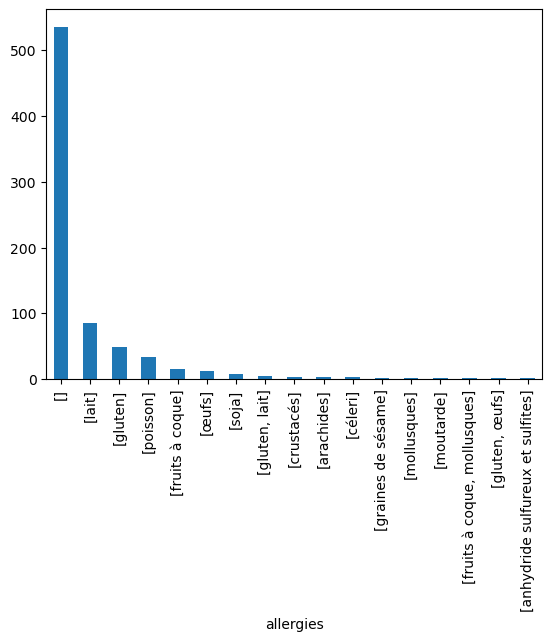

In [24]:
df_ingredients["allergies"].value_counts().plot.bar()

In [25]:
df_origines.head()

ingredient  chair-animale  lait  oeufs  miel  \
0                          eau-de-vie              0     0      0     0   
1                                rhum              0     0      0     0   
2  apéritif à base de vin ou vermouth              0     0      0     0   
3                               vodka              0     0      0     0   
4                     crème de cassis              0     1      0     0   

   champignons-levures  vegetaux  
0                    0         0  
1                    0         0  
2                    0         0  
3                    0         0  
4                    0         0

In [26]:
df_matches.head()

inca                              ciqual
0                          eau-de-vie                          Eau de vie
1                                rhum                                Rhum
2  apéritif à base de vin ou vermouth  Apéritif à base de vin ou vermouth
3                               vodka                               Vodka
4                     crème de cassis                     Crème de cassis

In [27]:
# joindre les nutriments à chaque ingrédient --- attach nutrients to each ingredient
df_ingredients = df_ingredients.join(df_matches.set_index("inca"), on="LIBING").join(df_ciqual.set_index("alim_nom_fr"), on="ciqual")

In [28]:
df_origines.head()

ingredient  chair-animale  lait  oeufs  miel  \
0                          eau-de-vie              0     0      0     0   
1                                rhum              0     0      0     0   
2  apéritif à base de vin ou vermouth              0     0      0     0   
3                               vodka              0     0      0     0   
4                     crème de cassis              0     1      0     0   

   champignons-levures  vegetaux  
0                    0         0  
1                    0         0  
2                    0         0  
3                    0         0  
4                    0         0

In [29]:
# joindre les informations sur les origines à chaque ingrédient -- attach origin information to each ingredient
df_ingredients = df_ingredients.join(df_origines.set_index("ingredient"), on="LIBING")

In [30]:
df_ingredients.head()

IDING                              LIBING  \
0      1                          eau-de-vie   
1      2                                rhum   
2      3  apéritif à base de vin ou vermouth   
3      4                               vodka   
4      5                     crème de cassis   

                              TYPING                SOURCE allergies  \
0  Ingrédient brut ou peu transformé   CIQUAL - base REGAL        []   
1  Ingrédient brut ou peu transformé   CIQUAL - base REGAL        []   
2  Ingrédient brut ou peu transformé   CIQUAL - base REGAL        []   
3  Ingrédient brut ou peu transformé  CIQUAL - base REGALa        []   
4  Ingrédient brut ou peu transformé   CIQUAL - base REGAL    [lait]   

                               ciqual  alim_grp_code  alim_ssgrp_code  \
0                          Eau de vie            6.0            603.0   
1                                Rhum            6.0            603.0   
2  Apéritif à base de vin ou vermouth            6.0            603.0   
3                               Vodka            6.0            603.0   
4                     Crème de cassis            6.0            603.0   

   alim_ssssgrp_code          alim_grp_nom_fr    alim_ssgrp_nom_fr  \
0            60303.0  eaux et autres boissons  boisson alcoolisées   
1            60303.0  eaux et autres boissons  boisson alcoolisées   
2            60303.0  eaux et autres boissons  boisson alcoolisées   
3            60303.0  eaux et autres boissons  boisson alcoolisées   
4            60303.0  eaux et autres boissons  boisson alcoolisées   

   alim_ssssgrp_nom_fr  alim_code alim_nom_sci  \
0  liqueurs et alcools     1001.0          NaN   
1  liqueurs et alcools     1004.0          NaN   
2  liqueurs et alcools     1007.0          NaN   
3  liqueurs et alcools     1008.0          NaN   
4  liqueurs et alcools     1021.0          NaN   

  Energie, Règlement UE N° 1169/2011 (kJ/100 g)  \
0                                           950   
1                                          1060   
2                                             -   
3                                          1000   
4                                          1030   

  Energie, Règlement UE N° 1169/2011 (kcal/100 g)  \
0                                             229   
1                                             256   
2                                               -   
3                                             242   
4                                             245   

  Energie, N x facteur Jones, avec fibres  (kJ/100 g)  \
0                                                 950   
1                                                1060   
2                                                   -   
3                                                1000   
4                                                1030   

  Energie, N x facteur Jones, avec fibres  (kcal/100 g) Eau (g/100 g)  \
0                                                   229          67,1   
1                                                   256          63,5   
2                                                     -          75,3   
3                                                   242          65,5   
4                                                   245          47,1   

  Protéines, N x facteur de Jones (g/100 g) Protéines, N x 6.25 (g/100 g)  \
0                                         0                             0   
1                                         0                             0   
2                                     0,054                         0,054   
3                                         0                             0   
4                                         0                             0   

  Glucides (g/100 g) Lipides (g/100 g) Sucres (g/100 g) Fructose (g/100 g)  \
0               0,37                 0                0                  -   
1                  0                 0                0                  -   
2              

In [31]:
df_ingredients.loc[df_ingredients["alim_ssgrp_nom_fr"] == "fruits à coque et graines oléagineuses"]

IDING                            LIBING  \
206    207                            amande   
207    208             cacahuète ou arachide   
208    209           cacahuète grillée salée   
209    210                          noisette   
210    211                              noix   
211    212  noix de coco amande mûre fraîche   
212    213         noix de coco amande sèche   
213    214                    noix du brésil   
214    215              pistache rôtie salée   
215    216        graine de sésame et autres   
216    217               graine de tournesol   
217    218               noix de cajou salée   
218    219           châtaigne cuite à l'eau   
219    220                 châtaigne grillée   
220    221                     pignon de pin   
221    222                     noix de pécan   
222    223        pâte d'amande industrielle   
358    359          graine de soja fermentée   
532    533            noix de coco en poudre   
545    546          pistache rôtie non salée   
573    574           sésame graines entières   

                                TYPING  \
206  Ingrédient brut ou peu transformé   
207  Ingrédient brut ou peu transformé   
208  Ingrédient brut ou peu transformé   
209  Ingrédient brut ou peu transformé   
210  Ingrédient brut ou peu transformé   
211  Ingrédient brut ou peu transformé   
212  Ingrédient brut ou peu transformé   
213  Ingrédient brut ou peu transformé   
214  Ingrédient brut ou peu transformé   
215  Ingrédient brut ou peu transformé   
216  Ingrédient brut ou peu transformé   
217  Ingrédient brut ou peu transformé   
218  Ingrédient brut ou peu transformé   
219  Ingrédient brut ou peu transformé   
220  Ingrédient brut ou peu transformé   
221  Ingrédient brut ou peu transformé   
222              Ingrédient transformé   
358  Ingrédient brut ou peu transformé   
532  Ingrédient brut ou peu transformé   
545  Ingrédient brut ou peu transformé   
573  Ingrédient brut ou peu transformé   

                                          SOURCE            allergies  \
206                          CIQUAL - base REGAL     [fruits à coque]   
207                          CIQUAL - base REGAL          [arachides]   
208                          CIQUAL - base REGAL          [arachides]   
209                          CIQUAL - base REGAL     [fruits à coque]   
210                          CIQUAL - base REGAL     [fruits à coque]   
211                          CIQUAL - base REGAL     [fruits à coque]   
212                          CIQUAL - base REGAL     [fruits à coque]   
213                          CIQUAL - base REGAL     [fruits à coque]   
214                          CIQUAL - base REGAL     [fruits à coque]   
215                          CIQUAL - base REGAL  [graines de sésame]   
216                          CIQUAL - base REGAL                   []   
217                          CIQUAL - base REGAL     [fruits à coque]   
218                          CIQUAL - base REGAL     [fruits à coque]   
219                          CIQUAL - base REGAL     [fruits à coque]   
220                          CIQUAL - base REGAL                   []   
221                          CIQUAL - base REGAL     [fruits à coque]   
222                          CIQUAL - base REGAL     [fruits à coque]   
358                          CIQUAL - base REGAL               [soja]   
532                 CIQUAL - base REGAL (proche)                   []   
545                 CIQUAL - base REGAL (proche)     [fruits à coque]   
573  USDA Food Compositon Data (Sesamum indicum)  [graines de sésame]   

                                 ciqual  alim_grp_code  alim_ssgrp_code  \
206                  Amande (avec peau)            2.0            205.0   
207               Cacahuète ou Arachide            2.0            205.0   
208           Cacahuète, grillée, salée            2.0            205.0   
209                            Noisette            2.0            205.0   
210                       Noix, fraîche  

Utiliser le groupe de l'ingrédient n'est pas très fiable pour détecter les allergies, certains ingrédients comme le pignon de pin ou les graines de tournesol ne sont pas allergènes mais sont présents dans le groupe des "fruits à coque et graines oléagineuses". 

Using the ingredient group is not very reliable to detect allergies, some ingredients such as pine nuts or sunflower seeds are not allergenic but are present in the group of "nuts and oilseeds".

In [32]:
df_recettes.columns, df_nomen.columns

(Index(['CODGR', 'SOUGR', 'CODAL', 'LIBAL'], dtype='object'),
 Index(['codgr', 'libgr', 'sougr', 'libsougr', 'codal', 'libal'], dtype='object'))

In [33]:
# on ajoute le libellé du groupe et du sous-groupe à la table de recettes --The group and subgroup label is added to the revenue table
df_recettes = df_recettes.merge(df_nomen[["libgr", "libsougr", "codal"]], left_on="CODAL", right_on="codal")
df_recettes.head(2)

CODGR  SOUGR  CODAL               LIBAL                       libgr  \
0      1      1   7001       pain baguette  pain et panification sèche   
1      1      1   7004  pain grillé maison  pain et panification sèche   

  libsougr  codal  
0     pain   7001  
1     pain   7004

In [37]:
# On ajoute aussi les aliments qui ne sont pas dans recettes et qui représentent en eux même des ingrédients.

# We also add foods that are not in recipes and which represent ingredients in themselves.
df_temp = df_nomen.loc[~df_nomen["codal"].isin(df_recettes["CODAL"])].merge(df_ingredients, left_on="libal", right_on="LIBING")[["codal", "libal", "IDING", "LIBING"]]
df_temp["PCTING"] = 100.0
df_temp.rename(columns={"codal": "CODAL", "libal": "LIBAL"}, inplace=True)
df_detail = pd.concat([df_detail, df_temp], ignore_index=True)
df_detail[df_detail['CODAL'] == 42]

CODAL                          LIBAL  IDING  \
0     42  cocktail genre punch planteur     12   
1     42  cocktail genre punch planteur      9   
2     42  cocktail genre punch planteur      6   
3     42  cocktail genre punch planteur      2   
4     42  cocktail genre punch planteur    253   
5     42  cocktail genre punch planteur    166   
6     42  cocktail genre punch planteur    447   
7     42  cocktail genre punch planteur    250   
8     42  cocktail genre punch planteur    108   

                                                        LIBING  PCTING  
0           jus de pamplemousse à base de concentré pasteurisé    22.0  
1                  jus d'orange à base de concentré pasteurisé    22.0  
2                  jus d'ananas à base de concentré pasteurisé    22.0  
3                                                         rhum    18.3  
4                                                          eau     8.0  
5                                                 citron frais     3.0  
6                                                   sucre roux     2.7  
7  sirop aux extraits de fruits à diluer type menthe ou fraise     2.0  
8                                                     cannelle     0.0

In [35]:
df_full = df_detail.merge(df_nomen, left_on="CODAL", right_on="codal").merge(df_ingredients, left_on="IDING", right_on="IDING")
df_full.loc[df_full["codgr"].isin([17, 18, 19, 20, 21, 22])].groupby("CODAL").apply(lambda x: (x["chair-animale"] == 1).any())[:20]

CODAL
6100    True
6110    True
6210    True
6220    True
6230    True
6253    True
6255    True
6257    True
6520    True
6550    True
6570    True
6999    True
8055    True
8081    True
8082    True
8110    True
8211    True
8232    True
8240    True
8291    True
dtype: bool

Le seul aliment dans ces groupes qui n'est pas marqué d'origine "chair animale" est le tarama, qui est produit des oeufs de lump. Donc toujours autorisé pour un profil végétarien.

The only food in these groups that is not marked as "animal flesh" in origin is tarama, which is produced from lumpfish eggs. So always authorized for a vegetarian profile.

In [36]:
df_full.loc[df_full["CODAL"] == 8293]

CODAL              LIBAL  IDING  \
987    8293  tarama industriel    237   
1228   8293  tarama industriel    104   
1566   8293  tarama industriel    705   
2207   8293  tarama industriel    634   
4145   8293  tarama industriel    386   
4146   8293  tarama industriel     57   
4160   8293  tarama industriel    753   
4161   8293  tarama industriel    738   
4167   8293  tarama industriel    613   

                                                           LIBING_x  PCTING  \
987                                                  huile végétale    47.0   
1228                                                sel fin ou gros     1.5   
1566                                                       arôme(s)     0.0   
2207                                          E330 - acide citrique     0.0   
4145                            œufs de lump ou lompe semi-conserve    45.0   
4146                                            chapelure ou panure     6.5   
4160              E262 - diacétate de sodium hydrogène conservateur     0.0   
4161                           E211 benzoate de sodium conservateur     0.0   
4167  E120 - cochenille - acide carminique - carmins colorant rouge     0.0   

      codgr     libgr  sougr                       libsougr  codal  \
987      21  poissons      3  produits dérivés des poissons   8293   
1228     21  poissons      3  produits dérivés des poissons   8293   
1566     21  poissons      3  produits dérivés des poissons   8293   
2207     21  poissons      3  produits dérivés des poissons   8293   
4145     21  poissons      3  produits dérivés des poissons   8293   
4146     21  poissons      3  produits dérivés des poissons   8293   
4160     21  poissons      3  produits dérivés des poissons   8293   
4161     21  poissons      3  produits dérivés des poissons   8293   
4167     21  poissons      3  produits dérivés des poissons   8293   

                  libal  \
987   tarama industriel   
1228  tarama industriel   
1566  tarama industriel   
2207  tarama industriel   
4145  tarama industriel   
4146  tarama industriel   
4160  tarama industriel   
4161  tarama industriel   
4167  tarama industriel   

                                                           LIBING_y  \
987                                                  huile végétale   
1228                                                sel fin ou gros   
1566                                                       arôme(s)   
2207                                          E330 - acide citrique   
4145                            œufs de lump ou lompe semi-conserve   
4146                                            chapelure ou panure   
4160              E262 - diacétate de sodium hydrogène conservateur   
4161                           E211 benzoate de sodium conservateur   
4167  E120 - cochenille - acide carminique - carmins colorant rouge   

                                 TYPING  \
987               Ingrédient transformé   
1228  Ingrédient brut ou peu transformé   
1566  Ingrédient brut ou peu transformé   
2207  Ingrédient brut ou peu transformé   
4145  Ingrédient brut ou peu transformé   
4146              Ingrédient transformé   
4160  Ingrédient brut ou peu transformé   
4161  Ingrédient brut ou peu transformé   
4167  Ingrédient brut ou peu transformé   

                                                                         SOURCE  \
987                                                         CIQUAL - base REGAL   
1228                                                        CIQUAL - base REGAL   
1566  La composition nutritionnelle n'est pas prise en compte dans les recettes   
2207  La composition nutritionnelle n'est pas prise en compte dans les recettes   
4145                                                        CIQUAL - base REGAL   
4146                                                        CIQUAL - base REGAL   
4160  La composition nutritionnelle n'est pas prise en compte dans les recettes   
4161  La composition nutri

# Construction de la base de connaissance -- Construction of the knowledge base

<img src="ressources/schema_kb.png">

---

### Les classes et propriétés -- Classes and properties
```    
- local:Food - DONE
    - rdfs:label                       rdf:langString
    - local:code                       xsd:integer
    - local:hasIncaGroup               inca:FoodGroup
    - local:hasIncaSubGroup            inca:FoodSubGroup
    - local:hasIngredientComposition*  local:IngredientComposition
    - local:hasCategory*  ???          local:FoodCategory

- inca:FoodSubGroup - DONE
    - rdfs:label                       rdf:langString
    - local:code                       xsd:integer

- inca:FoodGroup - DONE
    - rdfs:label                       rdf:langString
    - local:code                       xsd:integer

- local:FoodCategory - missing data
    - local:code                       xsd:integer
    
- local:IngredientComposition - DONE
    - local:hasIngredient              local:Ingredient
    - local:hasQuantity                xsd:decimal

- local:Ingredient - DONE
    - rdfs:label                       rdf:langString
    - local:code                       xsd:integer
    - local:hasCiqualGroup             ciqual:IngredientGroup
    - local:hasCiqualSubGroup          ciqual:IngredientSubGroup
    - local:hasCiqualSubSubGroup       ciqual:IngredientSubSubGroup
    - local:hasNutrimentComposition*   local:NutrimentComposition
    - local:causes*                    local:Allergy
    - local:isDerivedFrom*             local:Origin

- local:Origin - DONE
    - rdfs:label                       rdf:langString
    - local:code                       xsd:string

- ciqual:IngredientGroup - DONE
    - rdfs:label                       rdf:langString
    - local:code                       xsd:integer

- ciqual:IngredientSubGroup - DONE
    - rdfs:label                       rdf:langString
    - local:code                       xsd:integer
    - local:isSubGroupOf               local:IngredientGroup  ???

- ciqual:IngredientSubSubGroup - DONE
    - rdfs:label                       rdf:langString
    - local:code                       xsd:integer
    - local:isSubGroupOf               local:IngredientSubGroup  ???

- local:NutrimentComposition - DONE
    - local:hasNutriment               local:Nutriment
    - local:hasQuantity                xsd:decimal

- local:Nutriment - DONE
    - rdfs:label                       rdf:langString
    - local:code                       xsd:integer
    - loca:hasUnitOfMeasure            local:UnitOfMeasure

- local:UnitOfMeasure - DONE
    - rdfs:label                       xsd:string
    - local:code                       xsd:string

- local:Allergy - DONE
    - rdfs:label                       rdf:langString
    - local:code                       xsd:string

- local:Sex - DONE
    - rdfs:label                       rdf:langString

- local:Consumer (rdfs:subClassOf      foaf:Person)?  - DONE
    - local:code                       xsd:integer
    - local:hasAge                     xsd:integer
    - local:hasSex                     local:Sex    
    - local:hasConsumption*            local:WeeklyConsumption
    - local:hasConsumerProfile*        local:Profile
    
- local:ConsumerProfile - missing data

- local:WeeklyConsumption - DONE
    - local:isComposedOf*              local:DailyConsumption

- local:DailyConsumption - DONE
    - local:dayOfTheWeek               xsd:integer
    - local:isComposedOf*              local:Meal

- local:Meal - DONE
    - local:hasFoodComposition*        local:FoodComposition ????
    - local:hasConsumptionContext      local:ConsumptionContext
    - local:isOfType                   local:MealType

- local:FoodComposition - DONE
    - local:hasFood                    local:Food
    - local:hasNetQuantity             xsd:decimal
    - local:hasGrossQuantity           xsd:decimal

- local:MealType - DONE
    - rdfs:label                       rdf:langString

- local:ConsumptionContext - missing data
    - rdfs:label                       rdf:langString
    
- local:Recommendation
    - local:suggestsConsumption             local:WeeklyConsumption
    - local:forConsumer                local:Consumer
```

### Les données  - The dataframes
```
- df_ingredients
- df_recettes
- df_detail
- df_ciqual
- df_indiv
- df_conso
```

In [22]:
prefix_food_group = "food_group-"
prefix_food_subgroup = "food_subgroup-"
prefix_food = "food-"
prefix_food_category = "food_category-"
prefix_ingredient = "ingredient-"
prefix_ingredient_group = "ingredient_group-"
prefix_ingredient_subgroup = "ingredient_subgroup-"
prefix_ingredient_subsubgroup = "ingredient_subsubgroup-"
prefix_nutriment = "nutriment-"
prefix_unit_of_measure = "unit-"
prefix_allergy = "allergy-"
prefix_origin = "origin-"
prefix_sex = "sex-"
prefix_consumer = "consumer-"
prefix_meal_type = "meal_type-"
prefix_profile = "profile-"

local_ns = Namespace("http://example.org/1.0/local#")
inca_ns = Namespace("http://example.org/1.0/inca#")
ciqual_ns = Namespace("http://example.org/1.0/ciqual#")
    
def create_graph_with_ns():
    g = Graph()

    g.bind("local", local_ns)
    g.bind("inca", inca_ns)
    g.bind("ciqual", ciqual_ns)
    
    return g

g_food = create_graph_with_ns()

## `inca:FoodGroup` and `inca:FoodSubGroup`

In [23]:
def process_food_group(x):
    global g_food
    global inca_ns
    global ciqual_ns
    global local_ns
    
    group_code = str(int(x["codgr"].iloc[0]))
    group_label = str(x["libgr"].iloc[0])
    
    g_food.set((inca_ns[prefix_food_group + group_code], RDF.type, inca_ns.FoodGroup))
    g_food.set((inca_ns[prefix_food_group + group_code], RDFS.label, Literal(group_label, lang="fr")))
    g_food.set((inca_ns[prefix_food_group + group_code], local_ns.code, Literal(group_code, datatype=XSD.integer)))

_ = df_nomen[["codgr", "libgr"]].groupby("codgr").apply(process_food_group)

In [24]:
def process_food_subgroup(x):
    global g_food
    global inca_ns
    global ciqual_ns
    global local_ns
    
    subgroup_code = str(int(x["sougr"].iloc[0]))
    subgroup_label = str(x["libsougr"].iloc[0])
    
    g_food.set((inca_ns[prefix_food_subgroup + subgroup_code], RDF.type, inca_ns.FoodSubGroup))
    g_food.set((inca_ns[prefix_food_subgroup + subgroup_code], RDFS.label, Literal(subgroup_label, lang="fr")))
    g_food.set((inca_ns[prefix_food_subgroup + subgroup_code], local_ns.code, Literal(subgroup_code, datatype=XSD.integer)))

_ = df_nomen[["sougr", "libsougr"]].groupby("sougr").apply(process_food_subgroup)

## `local:Food`

In [25]:
def process_food(x):
    global g_food
    global inca_ns
    global ciqual_ns
    global local_ns
    
    food_code = str(int(x["codal"]))
    food_label = str(x["libal"])
    
    group_code = str(int(x["codgr"]))
    subgroup_code = str(int(x["sougr"]))
    
    g_food.set((local_ns[prefix_food + food_code], RDF.type, local_ns.Food))
    g_food.set((local_ns[prefix_food + food_code], RDFS.label, Literal(food_label, lang="fr")))
    g_food.set((local_ns[prefix_food + food_code], local_ns.code, Literal(food_code, datatype=XSD.integer)))
    
    g_food.set((local_ns[prefix_food + food_code], local_ns.hasIncaGroup, inca_ns[prefix_food_group + group_code]))
    g_food.set((local_ns[prefix_food + food_code], local_ns.hasIncaSubGroup, inca_ns[prefix_food_subgroup + subgroup_code]))

    for k, v in food_categories.items():
        if food_label in v:
            food_category_code = str(k)
            g_food.set((local_ns[prefix_food + food_code], local_ns.hasCategory, local_ns[prefix_food_category + food_category_code]))
            break
    
_ = df_nomen.apply(process_food, axis="columns")

## `local:FoodCategory`

In [26]:
for k, _ in food_categories.items():
    food_category_code = str(k)
    g_food.set((local_ns[prefix_food_category + food_category_code], RDF.type, local_ns.FoodCategory))
    g_food.set((local_ns[prefix_food_category + food_category_code], local_ns.code, Literal(food_category_code, datatype=XSD.integer)))

## `ciqual:IngredientGroup`, `ciqual:IngredientSubGroup` and `ciqual:IngredientSubSubGroup`

In [27]:
def process_ingredient_group(x):
    global g_food
    global inca_ns
    global ciqual_ns
    global local_ns
    
    group_code = str(int(x["alim_grp_code"].iloc[0]))
    group_label = str(x["alim_grp_nom_fr"].iloc[0])
    
    g_food.set((ciqual_ns[prefix_ingredient_group + group_code], RDF.type, ciqual_ns.IngredientGroup))
    g_food.set((ciqual_ns[prefix_ingredient_group + group_code], RDFS.label, Literal(group_label, lang="fr")))
    g_food.set((ciqual_ns[prefix_ingredient_group + group_code], local_ns.code, Literal(group_code, datatype=XSD.integer)))

_ = df_ingredients[["alim_grp_code", "alim_grp_nom_fr"]].groupby("alim_grp_code").apply(process_ingredient_group)

In [28]:
def process_ingredient_subgroup(x):
    global g_food
    global inca_ns
    global ciqual_ns
    global local_ns
    
    subgroup_code = str(int(x["alim_ssgrp_code"].iloc[0]))
    subgroup_label = str(x["alim_ssgrp_nom_fr"].iloc[0])
    
    g_food.set((ciqual_ns[prefix_ingredient_subgroup + subgroup_code], RDF.type, ciqual_ns.IngredientSubGroup))
    g_food.set((ciqual_ns[prefix_ingredient_subgroup + subgroup_code], RDFS.label, Literal(subgroup_label, lang="fr")))
    g_food.set((ciqual_ns[prefix_ingredient_subgroup + subgroup_code], local_ns.code, Literal(subgroup_code, datatype=XSD.integer)))

_ = df_ingredients[["alim_ssgrp_code", "alim_ssgrp_nom_fr"]].groupby("alim_ssgrp_code").apply(process_ingredient_subgroup)

In [29]:
def process_ingredient_subsubgroup(x):
    global g_food
    global inca_ns
    global ciqual_ns
    global local_ns

    subsubgroup_code = str(int(x["alim_ssssgrp_code"].iloc[0]))
    subsubgroup_label = str(x["alim_ssssgrp_nom_fr"].iloc[0])
    
    g_food.set((ciqual_ns[prefix_ingredient_subsubgroup + subsubgroup_code], RDF.type, ciqual_ns.IngredientSubSubGroup))
    g_food.set((ciqual_ns[prefix_ingredient_subsubgroup + subsubgroup_code], RDFS.label, Literal(subsubgroup_label, lang="fr")))
    g_food.set((ciqual_ns[prefix_ingredient_subsubgroup + subsubgroup_code], local_ns.code, Literal(subsubgroup_code, datatype=XSD.integer)))

_ = df_ingredients[["alim_ssssgrp_code", "alim_ssssgrp_nom_fr"]].groupby("alim_ssssgrp_code").apply(process_ingredient_subsubgroup)

## `local:Allergy`

In [30]:
def allergy_label2code(label):
    return label.replace(" ", "_")

def process_allergy(x):
    global g_food
    global inca_ns
    global ciqual_ns
    global local_ns
    
    allergy_label = str(x)
    allergy_code = allergy_label2code(allergy_label)
    
    g_food.set((local_ns[prefix_allergy + allergy_code], RDF.type, local_ns.Allergy))
    g_food.set((local_ns[prefix_allergy + allergy_code], RDFS.label, Literal(allergy_label, lang="fr")))
    g_food.set((local_ns[prefix_allergy + allergy_code], local_ns.code, Literal(allergy_code, datatype=XSD.string)))

for allergy in allergenes.keys():
    process_allergy(allergy)

## `local:Origin`

In [31]:
def process_origin(x):
    global g_food
    global inca_ns
    global ciqual_ns
    global local_ns
    
    origin_code = str(x)
    origin_label = origin_code
    
    g_food.set((local_ns[prefix_origin + origin_code], RDF.type, local_ns.Origin))
    g_food.set((local_ns[prefix_origin + origin_code], RDFS.label, Literal(origin_label, lang="fr")))
    g_food.set((local_ns[prefix_origin + origin_code], local_ns.code, Literal(origin_code, datatype=XSD.string)))
    
for origin in origines:
    process_origin(origin)

## `local:UnitOfMeasure`

In [32]:
def process_unit_of_measure(x):
    global g_food
    global inca_ns
    global ciqual_ns
    global local_ns
    
    unit_of_measure_code = str(x)
    unit_of_measure_label = unit_of_measure_code
    
    g_food.set((local_ns[prefix_unit_of_measure + unit_of_measure_code], RDF.type, local_ns.uniteOfMeasure))
    g_food.set((local_ns[prefix_unit_of_measure + unit_of_measure_code], RDFS.label,  Literal(unit_of_measure_label, datatype=XSD.string)))
    g_food.set((local_ns[prefix_unit_of_measure + unit_of_measure_code], local_ns.code,  Literal(unit_of_measure_code, datatype=XSD.string)))

for unit_of_measure in unites:
    process_unit_of_measure(unit_of_measure)

## `local:Nutriment`

In [33]:
def get_unit_of_measure_code_from_label(label):
    return re.findall(r"\((\w+)/100 g\)", nom)[0]

def process_nutriment(x):
    global g_food
    global inca_ns
    global ciqual_ns
    global local_ns
    
    nutriment_code = str(x[0])
    nutriment_label = str(x[1])
    unit_of_measure_code = get_unit_of_measure_code_from_label(nutriment_label)
    
    g_food.set((local_ns[prefix_nutriment + nutriment_code], RDF.type, local_ns.Nutriment))
    g_food.set((local_ns[prefix_nutriment + nutriment_code], RDFS.label, Literal(nutriment_label, lang="fr")))
    g_food.set((local_ns[prefix_nutriment + nutriment_code], local_ns.code, Literal(nutriment_code, datatype=XSD.string)))
    g_food.set((local_ns[prefix_nutriment + nutriment_code], local_ns.hasUnitOfMeasure, local_ns[prefix_unit_of_measure + unit_of_measure_code]))

for x in nutriments.items():
    process_nutriment(x)

## `local:Ingredient`, `local:NutrimentComposition` and `local:IngredientComposition`

In [34]:
def process_ingredient(x):
    global g_food
    global inca_ns
    global ciqual_ns
    global local_ns
    
    ingredient_code = str(int(x["IDING"]))
    ingredient_label = str(x["LIBING"])
    
    g_food.set((local_ns[prefix_ingredient + ingredient_code], RDF.type, local_ns.Ingredient))
    g_food.set((local_ns[prefix_ingredient + ingredient_code], RDFS.label, Literal(ingredient_label, lang="fr")))
    g_food.set((local_ns[prefix_ingredient + ingredient_code], local_ns.code, Literal(ingredient_code, datatype=XSD.integer)))
    
    # group, subgroup, subsubgroup
    try:
        group_code = str(int(x["alim_grp_code"]))
        g_food.set((local_ns[prefix_ingredient + ingredient_code], local_ns.hasCiqualGroup, ciqual_ns[prefix_ingredient_group + group_code]))
    except:
        pass
    try:
        subgroup_code = str(int(x["alim_ssgrp_code"]))
        g_food.set((local_ns[prefix_ingredient + ingredient_code], local_ns.hasCiqualSubGroup, ciqual_ns[prefix_ingredient_subgroup + subgroup_code]))
    except:
        pass
    try:
        subsubgroup_code = str(int(x["alim_ssssgrp_code"]))
        g_food.set((local_ns[prefix_ingredient + ingredient_code], local_ns.hasCiqualSubSubGroup, ciqual_ns[prefix_ingredient_subsubgroup + subsubgroup_code]))
    except:
        pass
    
    # allergy
    for allergy_label in x["allergies"]:
        allergy_code = allergy_label2code(allergy_label)
        
        g_food.add((local_ns[prefix_ingredient + ingredient_code], local_ns.causes, local_ns[prefix_allergy + allergy_code]))
    
    # origin
    for origin_code in origines:
        if x[origin_code] == 1:
            g_food.add((local_ns[prefix_ingredient + ingredient_code], local_ns.isDerivedFrom, local_ns[prefix_origin + origin_code]))

    # nutriments
    for nutriment_code, nutriment_label in nutriments.items():
        try:
            quantity = str(float(x[nutriment_label].replace(",", ".")))
        except:
            quantity = str(float(0))
        composition = BNode()
        
        g_food.add((local_ns[prefix_ingredient + ingredient_code], local_ns.hasNutrimentComposition, composition))
        g_food.set((composition, RDF.type, local_ns.NutrimentComposition))
        g_food.set((composition, local_ns.hasNutriment, local_ns[prefix_nutriment + nutriment_code]))
        g_food.set((composition, local_ns.hasQuantity, Literal(quantity, datatype=XSD.decimal)))
    
_ = df_ingredients.apply(process_ingredient, axis="columns")

In [35]:
def process_ingredient_composition(x):
    global g_food
    global inca_ns
    global ciqual_ns
    global local_ns
    
    ingredient_code = str(int(x["IDING"]))
    food_code = str(int(x["CODAL"]))

    quantity = str(float(x["PCTING"]))
    
    composition = BNode()
    
    g_food.add((local_ns[prefix_food + food_code], local_ns.hasIngredientComposition, composition))
    g_food.set((composition, RDF.type, local_ns.IngredientComposition))
    g_food.set((composition, local_ns.hasIngredient, local_ns[prefix_ingredient + ingredient_code]))
    g_food.set((composition, local_ns.hasQuantity, Literal(quantity, datatype=XSD.decimal)))

_ = df_detail.apply(process_ingredient_composition, axis="columns")

## `local:Sex`

In [36]:
sex_code2label = {
    1: "masculin",
    2: "feminin"
}

for sex_label in sex_code2label.values():
    g_food.set((local_ns[prefix_sex + sex_label], RDF.type, local_ns.Sex))
    g_food.set((local_ns[prefix_sex + sex_label], RDFS.label, Literal(sex_label, lang="fr")))

## `local:MealType`

In [37]:
meal_type_code2label = {
    "1": "petit-dejeuner",
    "3": "dejeuner",
    "5": "diner"
}

for meal_type_label in meal_type_code2label.values():
    g_food.set((local_ns[prefix_meal_type + meal_type_label], RDF.type, local_ns.MealType))
    g_food.set((local_ns[prefix_meal_type + meal_type_label], RDFS.label, Literal(meal_type_label, lang="fr")))

## `local:Consumer`

In [38]:
consumer_graphs = dict()

def process_consumer(x):
    global inca_ns
    global ciqual_ns
    global local_ns
    
    consumer_code = str(int(x["nomen"]))
    sex_label = sex_code2label[int(x["sexe_ps"])]
    age = str(int(x["v2_age"]))
    
    consumer_graphs[consumer_code] = create_graph_with_ns()
    
    consumer_graphs[consumer_code].set((local_ns[prefix_consumer + consumer_code], RDF.type, local_ns.Consumer))
    consumer_graphs[consumer_code].set((local_ns[prefix_consumer + consumer_code], local_ns.code, Literal(consumer_code, datatype=XSD.integer)))
    consumer_graphs[consumer_code].set((local_ns[prefix_consumer + consumer_code], local_ns.hasAge, Literal(age, datatype=XSD.integer)))
    consumer_graphs[consumer_code].set((local_ns[prefix_consumer + consumer_code], local_ns.hasSex, local_ns[prefix_sex + sex_label]))

_ = df_indiv.apply(process_consumer, axis="columns")

## `local:WeeklyConsumption`, `local:DailyConsumption`, `local:Meal` and `local:FoodComposition`

In [39]:
def process_food_composition(x, meal, g):
    global inca_ns
    global ciqual_ns
    global local_ns
    
    food_code = str(int(x["codal"]))
    net_quantity = str(float(x["qte_nette"]))
    gross_quantity = str(float(x["qte_brute"]))
    
    food_composition = BNode()
    
    g.add((meal, local_ns.hasFoodComposition, food_composition))
    g.set((food_composition, local_ns.hasNetQuantity, Literal(net_quantity, datatype=XSD.decimal)))
    g.set((food_composition, local_ns.hasGrossQuantity, Literal(gross_quantity, datatype=XSD.decimal)))
    g.set((food_composition, local_ns.hasFood, local_ns[prefix_food + food_code]))

def process_meal(x, daily_consumption, g):
    global inca_ns
    global ciqual_ns
    global local_ns
    
    meal_type_code = str(int(x["tyrep"].iloc[0]))
    if meal_type_code not in meal_type_code2label:
        return
    meal_type_label = meal_type_code2label[meal_type_code]
    
    meal = BNode()
    
    g.add((daily_consumption, local_ns.isComposedOf, meal))
    g.set((meal, RDF.type, local_ns.Meal))
    g.set((meal, local_ns.isOfType, local_ns[prefix_meal_type + meal_type_label]))
    
    x.apply(process_food_composition, args=(meal, g), axis="columns")

def process_daily_consumption(x, weekly_consumption, g):
    global inca_ns
    global ciqual_ns
    global local_ns
    
    day_of_the_week = str(int(x["nojour"].iloc[0]))
    
    daily_consumption = BNode()
    
    g.add((weekly_consumption, local_ns.isComposedOf, daily_consumption))
    g.set((daily_consumption, RDF.type, local_ns.DailyConsumption))
    g.set((daily_consumption, local_ns.dayOfTheWeek, Literal(day_of_the_week, datatype=XSD.integer)))
    
    x.groupby("tyrep").apply(process_meal, daily_consumption, g)
    
def process_weekly_consumption(x):
    global inca_ns
    global ciqual_ns
    global local_ns
    
    consumer_code = str(int(x["nomen"].iloc[0]))
    
    g = consumer_graphs[consumer_code]
    
    weekly_consumption = BNode()
    
    g.add((local_ns[prefix_consumer + consumer_code], local_ns.hasConsumption, weekly_consumption))
    g.set((weekly_consumption, RDF.type, local_ns.WeeklyConsumption))
    
    x.groupby("nojour").apply(process_daily_consumption, weekly_consumption, g)

_ = df_conso.groupby("nomen").apply(process_weekly_consumption)

## `local:ConsumerProfile`

In [40]:
profile_label = "ovo-lacto-vegetarien"
g_food.set((local_ns[prefix_profile + profile_label], RDF.type, local_ns.ConsumerProfile))
g_food.add((local_ns[prefix_profile + profile_label], local_ns.doesNotEat, local_ns[prefix_origin + "chair-animale"]))

profile_label = "lacto-vegetarien"
g_food.set((local_ns[prefix_profile + profile_label], RDF.type, local_ns.ConsumerProfile))
g_food.add((local_ns[prefix_profile + profile_label], local_ns.doesNotEat, local_ns[prefix_origin + "chair-animale"]))
g_food.add((local_ns[prefix_profile + profile_label], local_ns.doesNotEat, local_ns[prefix_origin + "oeufs"]))

profile_label = "ovo-vegetarien"
g_food.set((local_ns[prefix_profile + profile_label], RDF.type, local_ns.ConsumerProfile))
g_food.add((local_ns[prefix_profile + profile_label], local_ns.doesNotEat, local_ns[prefix_origin + "chair-animale"]))
g_food.add((local_ns[prefix_profile + profile_label], local_ns.doesNotEat, local_ns[prefix_origin + "lait"]))

profile_label = "vegetalien"
g_food.set((local_ns[prefix_profile + profile_label], RDF.type, local_ns.ConsumerProfile))
g_food.add((local_ns[prefix_profile + profile_label], local_ns.doesNotEat, local_ns[prefix_origin + "chair-animale"]))
g_food.add((local_ns[prefix_profile + profile_label], local_ns.doesNotEat, local_ns[prefix_origin + "lait"]))
g_food.add((local_ns[prefix_profile + profile_label], local_ns.doesNotEat, local_ns[prefix_origin + "oeufs"]))
g_food.add((local_ns[prefix_profile + profile_label], local_ns.doesNotEat, local_ns[prefix_origin + "miel"]))

<Graph identifier=N38bf868b713243b69d426de23bb78124 (<class 'rdflib.graph.Graph'>)>

In [41]:
for allergy_label in allergenes.keys():
    allergy_code = allergy_label2code(allergy_label)
    
    profile_label = "allergique-" + allergy_code
    g_food.set((local_ns[prefix_profile + profile_label], RDF.type, local_ns.ConsumerProfile))
    g_food.set((local_ns[prefix_profile + profile_label], local_ns.hasAllergy, local_ns[prefix_allergy + allergy_code]))

# Sérialisation Turtle 

In [42]:
with open("kb/kb_food.ttl", "w") as file:
    file.write(g_food.serialize())
    
for k, v in consumer_graphs.items():
    with open(f"kb/consumer_kbs/{k}.ttl", "w") as file:
        file.write(v.serialize())

C:\Protege-5.6.3\plugins\Graphviz\bin